The objective of this file is to create a pipeline to train an XGBoost model on any given set of X features and y labels.

In [1]:
%load_ext cuml.accel

cuML: Accelerator installed.


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score  # Import cross_val_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [3]:
def run_XGBoost(X, y, target_names=None, feature_names=None):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the features using StandardScaler
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)  # Fit to the training data and transform
    X_test = scaler.transform(X_test)  # Only transform the test data

    # Label encode the genre labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)  # Converts genre names to numeric labels
    y_test_encoded = label_encoder.transform(y_test)

    model = XGBClassifier(use_label_encoder=None, eval_metric='mlogloss')

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5)  # Using 5-fold cross-validation
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Mean Cross-Validation Score: {np.mean(cv_scores):.2f}')

    # Fit the model on the full training set after cross-validation
    model.fit(X_train, y_train_encoded)

    # Assign feature names so XGBoost uses them for plotting and other outputs
    model.get_booster().feature_names = feature_names

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Decode predictions back to genre names
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_test_decoded = label_encoder.inverse_transform(y_test_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    if target_names is None:
        target_names = [str(label) for label in label_encoder.classes_]
    # Print classification report
    print(classification_report(y_test_encoded, y_pred, target_names=target_names))

    # Confusion Matrix Visualization
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix: Actual vs Predicted')
    plt.show()

    # Plot Feature Importance
    plt.figure(figsize=(12, 10))
    plot_importance(model, max_num_features=10, importance_type='weight')  # Adjust max_num_features as needed
    plt.title('Feature Importance')
    plt.show()

In [4]:
with open("/home/tyler/gdrive/K-pop Project 2024-5/K-pop Project/ML_inputs/features.pkl", 'rb') as f:
    DATA = pickle.load(f)
with open('/home/tyler/Downloads/kpop_project/ML_inputs/feature_names.pkl', 'rb') as f:
    FEATURE_NAMES = pickle.load(f)
with open('/home/tyler/gdrive/K-pop Project 2024-5/K-pop Project/ML_inputs/gen_labels.pkl', 'rb') as f:
    generation_labels = pickle.load(f)

# Convert lists to numpy arrays after processing all files
DATA = np.array(DATA)  # Convert to numpy array
generation_labels = np.array(generation_labels)  # Convert to numpy array

Cross-Validation Scores: [0.70700046 0.70885489 0.71566014 0.71960125 0.72029674]
Mean Cross-Validation Score: 0.71
Accuracy: 0.72
              precision    recall  f1-score   support

           1       0.75      0.76      0.75      2701
           2       0.70      0.75      0.73      3653
           3       0.71      0.74      0.72      3154
           4       0.78      0.50      0.61      1197
           5       1.00      0.28      0.43        80

    accuracy                           0.72     10785
   macro avg       0.79      0.61      0.65     10785
weighted avg       0.73      0.72      0.72     10785



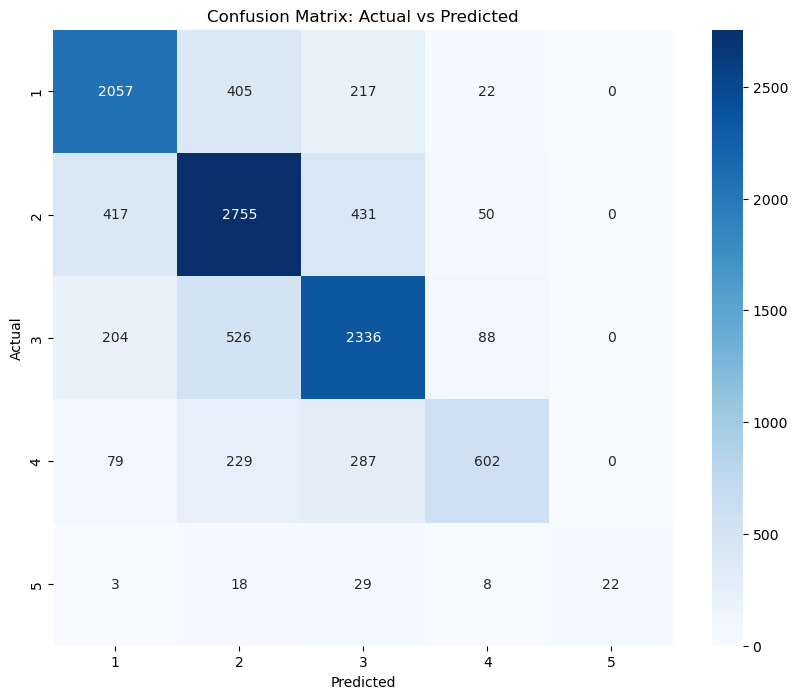

<Figure size 1200x1000 with 0 Axes>

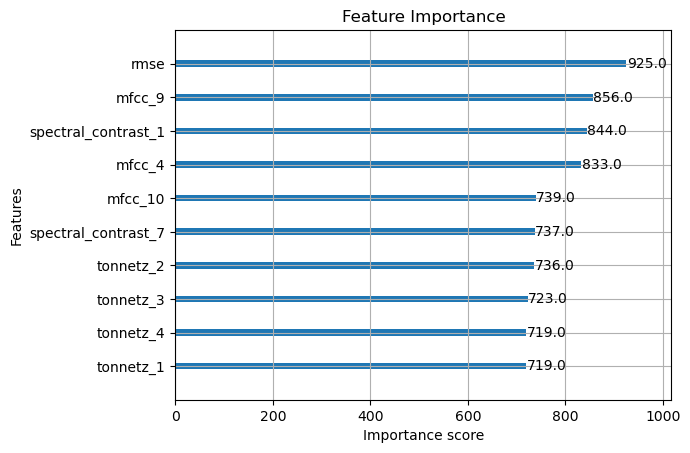

In [5]:
# run XGBoost on generation labels
run_XGBoost(X=DATA, y=generation_labels, feature_names=FEATURE_NAMES)

In [6]:
def int_to_company(num: int):
    if num == 7:
        return 'JYP'
    elif num == 9:
        return 'SM'
    elif num == 11:
        return 'YG'

In [7]:
with open('/home/tyler/gdrive/K-pop Project 2024-5/K-pop Project/ML_inputs/company_labels.pkl', 'rb') as f:
    company_labels = pickle.load(f)
label_encoder = LabelEncoder()
label_encoder.fit_transform(company_labels)
target_names = [int_to_company(num) for num in label_encoder.classes_]

Cross-Validation Scores: [0.76703755 0.76553083 0.77164715 0.76677872 0.76677872]
Mean Cross-Validation Score: 0.77
Accuracy: 0.78
              precision    recall  f1-score   support

         JYP       0.76      0.64      0.70      3055
          SM       0.77      0.88      0.83      5626
          YG       0.82      0.69      0.75      2104

    accuracy                           0.78     10785
   macro avg       0.79      0.74      0.76     10785
weighted avg       0.78      0.78      0.78     10785



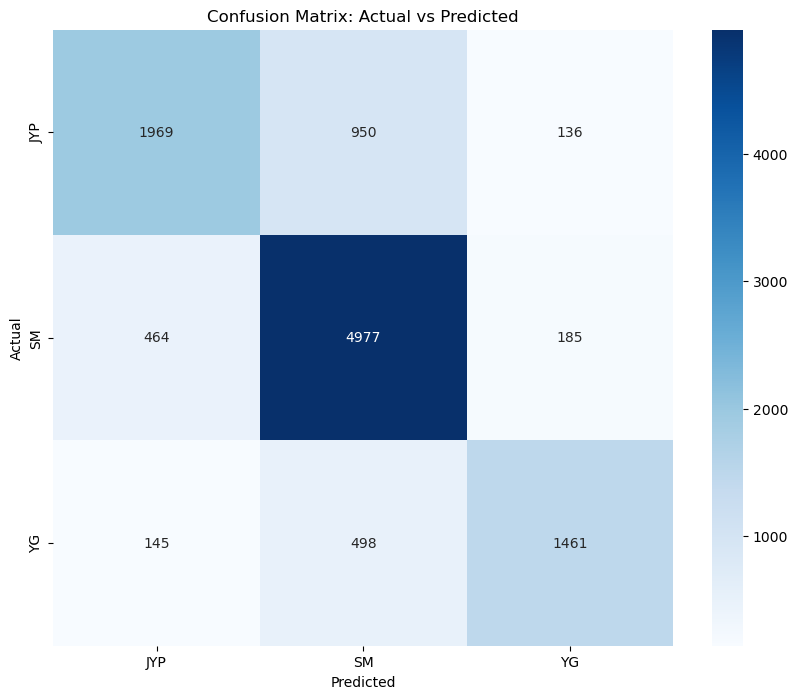

<Figure size 1200x1000 with 0 Axes>

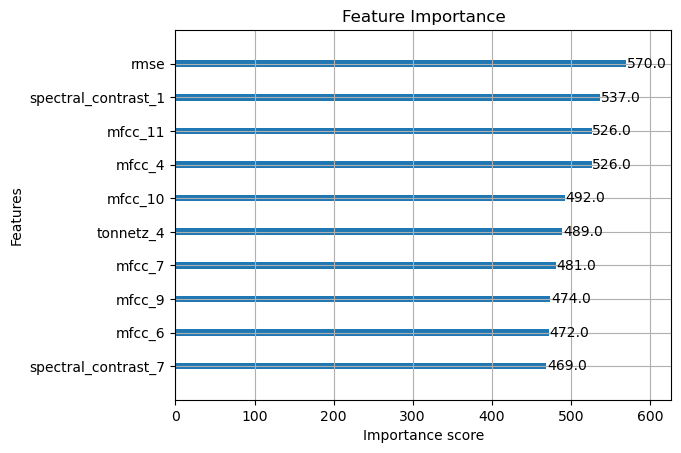

In [8]:
# run XGBoost on company labels
run_XGBoost(X=DATA, y=company_labels, target_names=target_names, feature_names=FEATURE_NAMES) 

In [9]:
def num_to_company_gen(num: int):
    if num % 7 == 0:
        return "JYP, " + str(num // 7)
    elif num % 9 == 0:
        return 'SM, ' + str(num // 9)
    elif num % 11 == 0:
        return 'YG, ' + str(num // 11)
    return None
    

In [10]:
company_and_generation_labels = np.multiply(company_labels, generation_labels)
label_encoder = LabelEncoder()
label_encoder.fit_transform(company_and_generation_labels)
target_names = [num_to_company_gen(num) for num in label_encoder.classes_]

Cross-Validation Scores: [0.67246175 0.67848864 0.67508983 0.68065376 0.66906225]
Mean Cross-Validation Score: 0.68
Accuracy: 0.69
              precision    recall  f1-score   support

      JYP, 1       0.83      0.55      0.67       271
       SM, 1       0.67      0.83      0.74      2430
      JYP, 2       0.77      0.47      0.59       731
       SM, 2       0.62      0.73      0.67      2124
      JYP, 3       0.66      0.64      0.65      1269
       YG, 2       0.84      0.70      0.77       798
       SM, 3       0.72      0.55      0.62       836
      JYP, 4       0.70      0.60      0.64       780
       YG, 3       0.75      0.78      0.77      1049
      JYP, 5       1.00      0.25      0.40         4
       SM, 4       0.89      0.51      0.65       187
       YG, 4       0.92      0.71      0.80       230
       SM, 5       1.00      0.33      0.49        49
       YG, 5       1.00      0.30      0.46        27

    accuracy                           0.69     10785
   

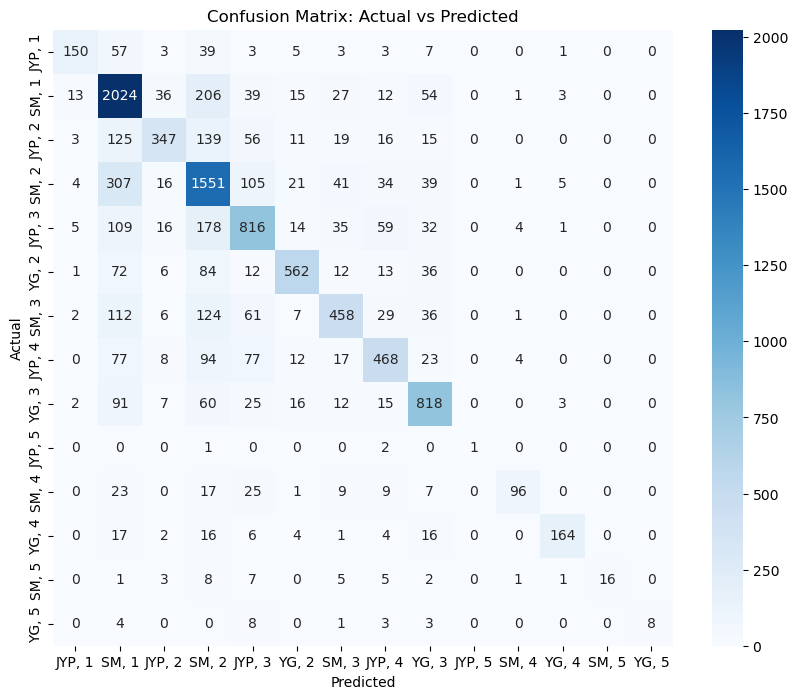

<Figure size 1200x1000 with 0 Axes>

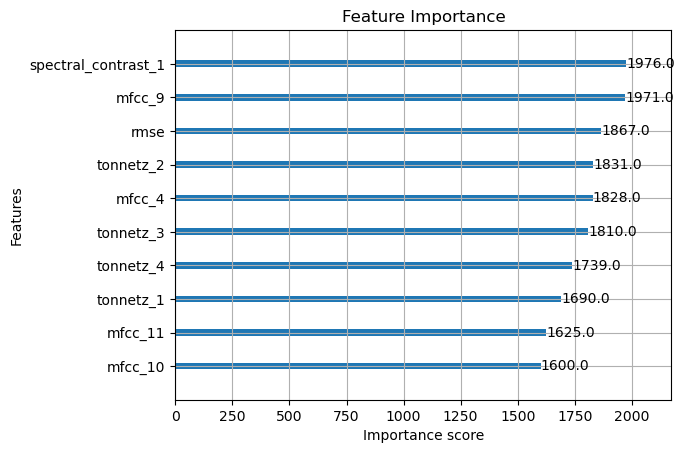

In [11]:
# run XGBoost on company * generation
run_XGBoost(X=DATA, y=company_and_generation_labels, target_names=target_names, feature_names=FEATURE_NAMES)